In [122]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import optimize
from scipy.optimize import minimize

from correlation import (
    create_buckets, 
    calc_contingency_table, 
    chi_squared_statistic,
)
from utils import (
    plot_contingency_table,
    plot_binorm_distr_2d,
    plot_binorm_distr_3d,
)
from integrals import (
    calc_integral_between
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
df = pd.read_csv('data/fake_insurance_data.csv')
df.head(10)

,car_color,driver_age,area,mileage,car_size
0,black,26.377219,suburbs,156806.288398,XXL
1,black,58.976840,suburbs,74400.323559,XL
2,multicolor,55.744988,downtown,267856.748015,XXL
3,metalic,57.629139,downtown,259028.249060,XXL
4,green,21.490637,downtown,110712.216080,XL
5,gray,50.052691,downtown,166848.529135,XXL
6,black,27.849175,suburbs,27533.843483,XL
7,blue,42.927957,hills,189280.320650,XL
8,metalic,73.966067,hills,180140.764820,XXL
9,gray,18.988367,downtown,183291.533883,XXL


# Split into buckets

In [87]:
buckets, bucket2interval = create_buckets(df['driver_age'].values, bins=10)
bucket2interval

{1: '18.031 - 28.345',
 2: '28.345 - 38.660',
 3: '38.660 - 48.974',
 4: '48.974 - 59.289',
 5: '59.289 - 69.603',
 6: '69.603 - 79.918',
 7: '79.918 - 90.232',
 8: '90.232 - 100.547',
 9: '100.547 - 110.862',
 10: '110.862 - 121.176'}

# Contingency table

In [88]:
ctable, meta = calc_contingency_table(
    x=df['mileage'].values,
    y=df['car_size'].values, 
    xbins=10,
    ybins=10,
    xlabel='mileage',
    ylabel='car_size'
)
ctable

array([[ 62, 115,  78,   6,  32,   0],
       [108,  10,   0,  51,   0,   4],
       [ 13,   0,   0,  63,   0,  14],
       [  2,   0,   0,  94,   0,  36],
       [  0,   0,   0, 131,   0, 168],
       [  0,   0,   0,  73,   0, 217],
       [  0,   0,   0,  14,   0, 155],
       [  0,   0,   0,   0,   0,  76],
       [  0,   0,   0,   0,   0, 155],
       [  0,   0,   0,   0,   0, 323]])

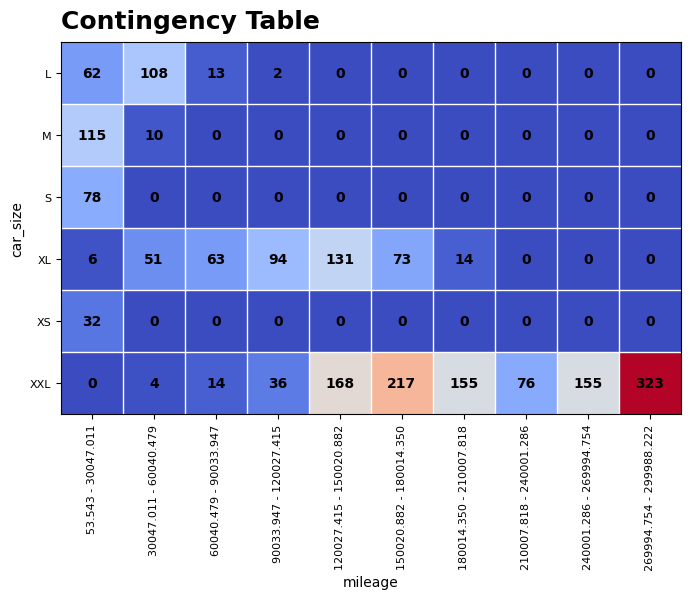

In [89]:
plot_contingency_table(table=ctable, meta=meta)

# Chi-squared statistic

In [121]:
ctable_chi2 = chi_squared_statistic(table=ctable)
ctable_chi2

2995.253108174877

# Bi-variate normal distribution as function of rho

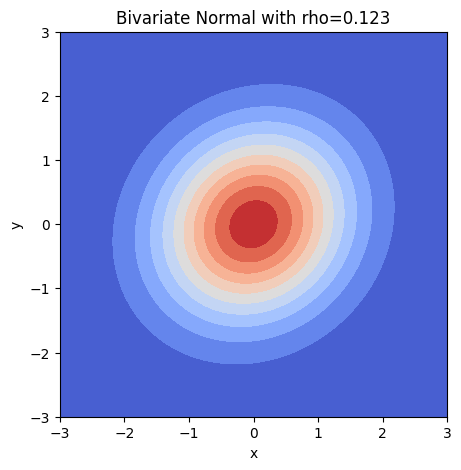

In [11]:
plot_binorm_distr_2d(rho=0.123)

# Make grid

In [12]:
nx, ny = (50, 50)
sx = np.linspace(-5, 5, nx + 1)
sy = np.linspace(-5, 5, ny + 1)

grid = []
for i in range(nx):
    for j in range(ny):
        lower = [sx[i], sy[j]]
        upper = [sx[i + 1], sy[j + 1]]
        grid.append((lower, upper))

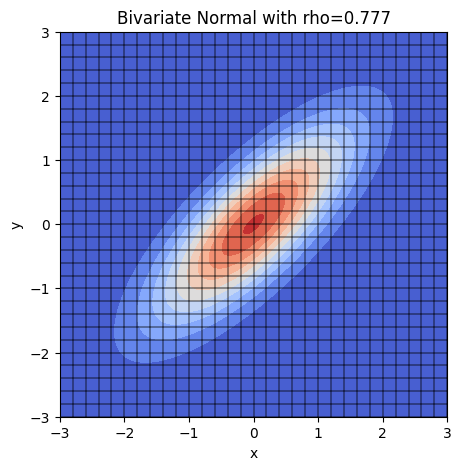

In [13]:
plot_binorm_distr_2d(rho=0.777, grid=grid)

In [14]:
# check that total integral is 1

rho = 0.1
mu = np.array([0.0, 0.0])
S = np.array([[1.0, rho], [rho, 1.0]])

total_itegral = 0
for (lower, upper) in grid:
    total_itegral += calc_integral_between(lower, upper, mu, S)
total_itegral

0.999998853395639

# Calculate phi_K

In [120]:
for rho in np.linspace(0.01, 0.99, num=20):

    chi2 = 0
    for (lower, upper) in grid:

        mu = np.array([0.0, 0.0])
        S_rho = np.array([[1.0, rho], [rho, 1.0]])
        S_0 = np.array([[1.0, 0.0], [0.0, 1.0]])

        f_ij_rho = calc_integral_between(lower, upper, mu=mu, S=S_rho)
        f_ij_0 = calc_integral_between(lower, upper, mu=mu, S=S_0)
        chi2 += (f_ij_rho - f_ij_0)**2 / f_ij_0

    chi2 *= ctable.sum()
    
    print(f'rho={rho:.3f} --> chi2={chi2:.3f}')

rho=0.010 --> chi2=0.199
rho=0.062 --> chi2=7.562
rho=0.113 --> chi2=25.766
rho=0.165 --> chi2=55.408
rho=0.216 --> chi2=97.491
rho=0.268 --> chi2=153.517
rho=0.319 --> chi2=225.625
rho=0.371 --> chi2=316.814
rho=0.423 --> chi2=431.277
rho=0.474 --> chi2=574.951
rho=0.526 --> chi2=756.379
rho=0.577 --> chi2=988.176
rho=0.629 --> chi2=1289.563
rho=0.681 --> chi2=1691.035
rho=0.732 --> chi2=2243.574
rho=0.784 --> chi2=3038.707
rho=0.835 --> chi2=4258.888
rho=0.887 --> chi2=6335.471
rho=0.938 --> chi2=10686.709
rho=0.990 --> chi2=30866.972


# Calculate phi_K (optimizer)

In [124]:
def objective_function(rho, target=ctable_chi2):
    
    chi2 = 0

    for (lower, upper) in grid:
        mu = np.array([0.0, 0.0])
        S_rho = np.array([[1.0, rho], [rho, 1.0]])
        S_0 = np.array([[1.0, 0.0], [0.0, 1.0]])

        f_ij_rho = calc_integral_between(lower, upper, mu=mu, S=S_rho)
        f_ij_0 = calc_integral_between(lower, upper, mu=mu, S=S_0)
        chi2 += (f_ij_rho - f_ij_0) ** 2 / f_ij_0

    chi2 *= ctable.sum()
    return chi2 - target


rho_solution = optimize.brentq(f=objective_function, a=0, b=1, args=(ctable_chi2))
print("Optimal rho:", rho_solution)

Optimal rho: 0.7813395319480057
